In [5]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly 
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn import metrics

In [0]:
df = pd.read_csv(r"bank-additional-full.csv",delimiter = ";",na_values=["unknown"])

In [31]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
df.shape

(41188, 21)

In [0]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [32]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The above is the descriptive stats table for the numeric data only. Thus not much info can be inferred, 
Some key inghts are :

* Mean age is 40 years, while min is 17 and max is 98
* The mean duration of call is 258 sec(4.3 min) while max is 4918 sec(81 min). Also this is a very highly correlated column with target as the sales person will talk for longer duration with a potential client only.


In [0]:
df["pdays"].value_counts().sort_index()

0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
Name: pdays, dtype: int64

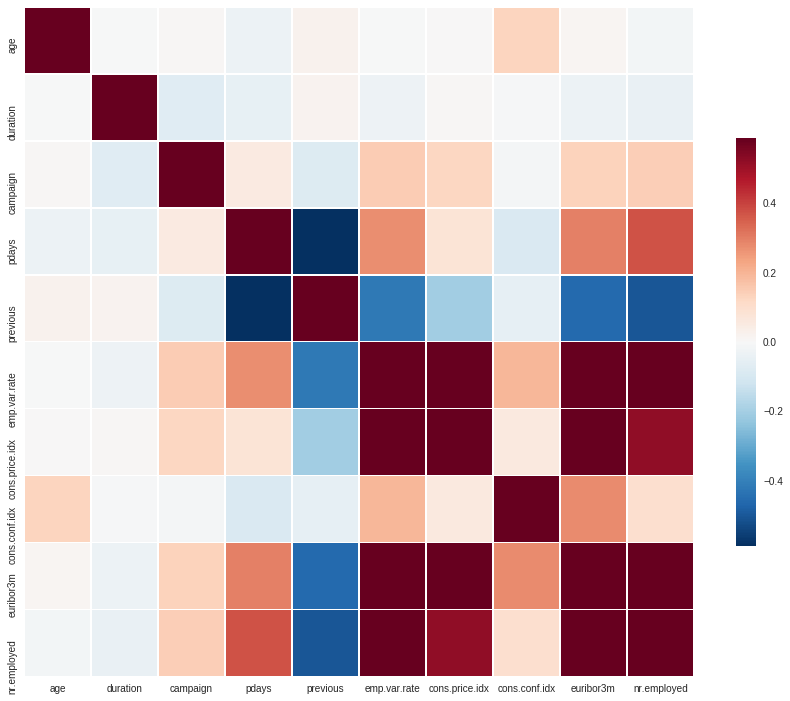

In [0]:
sns.set(style="white")

corr = df.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

None of the features is correlated with "y" ( target class), thus combination of features will be used

In [0]:
df.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

All the columns which have null values are categorical, thus the unknown values can be replaced bt the respective mode of the columns. These were represented as null values

y
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

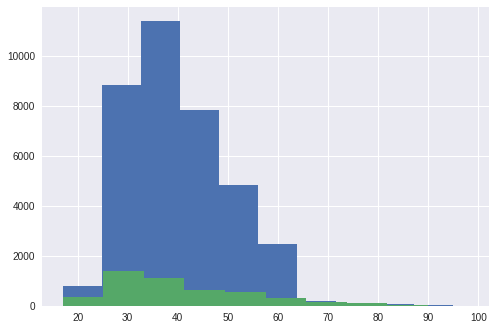

In [0]:
df.groupby("y").age.hist()

In [33]:
df["job"].value_counts()/len(df) *100

admin.           25.303486
blue-collar      22.467709
technician       16.371273
services          9.636302
management        7.099155
retired           4.175974
entrepreneur      3.535010
self-employed     3.450034
housemaid         2.573565
unemployed        2.461882
student           2.124405
Name: job, dtype: float64

In [0]:
df_yes = df.loc[df["y"] == "yes"]

In [36]:
df_yes.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,blue-collar,divorced,basic.4y,NaN,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,NaN,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,NaN,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,NaN,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


In [0]:
jobs = df["job"].unique().tolist()

admin = df_yes["age"].loc[df_yes["job"] == "admin"].values
blue_collar = df_yes["age"].loc[df_yes["job"] == "blue-collar"].values
technician = df_yes["age"].loc[df_yes["job"] == "technician"].values
services = df_yes["age"].loc[df_yes["job"] == "services"].values
management = df_yes["age"].loc[df_yes["job"] == "management"].values
retired = df_yes["age"].loc[df_yes["job"] == "retired"].values
entrepreneur = df_yes["age"].loc[df_yes["job"] == "entrepreneur"].values
self_employed = df_yes["age"].loc[df_yes["job"] == "self-employed"].values
housemaid = df_yes["age"].loc[df_yes["job"] == "housemaid"].values
unemployed = df_yes["age"].loc[df_yes["job"] == "unemployed"].values
student = df_yes["age"].loc[df_yes["job"] == "student"].values
unknown = df_yes["age"].loc[df_yes["job"] == "unknown"].values



ages = [admin, blue_collar, technician, services, management, retired, self_employed, 
         entrepreneur, housemaid, unemployed, unknown]

In [0]:
import plotly.plotly as py

N= 11
colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

traces = []
for job, age,c in zip(jobs, ages,colors):
        traces.append(go.Box(
            y=age,
            name=job,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=c,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Job',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend =False
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

The link to the plot : 
https://plot.ly/~Dishha.m/328/distribution-of-ages-by-job/

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



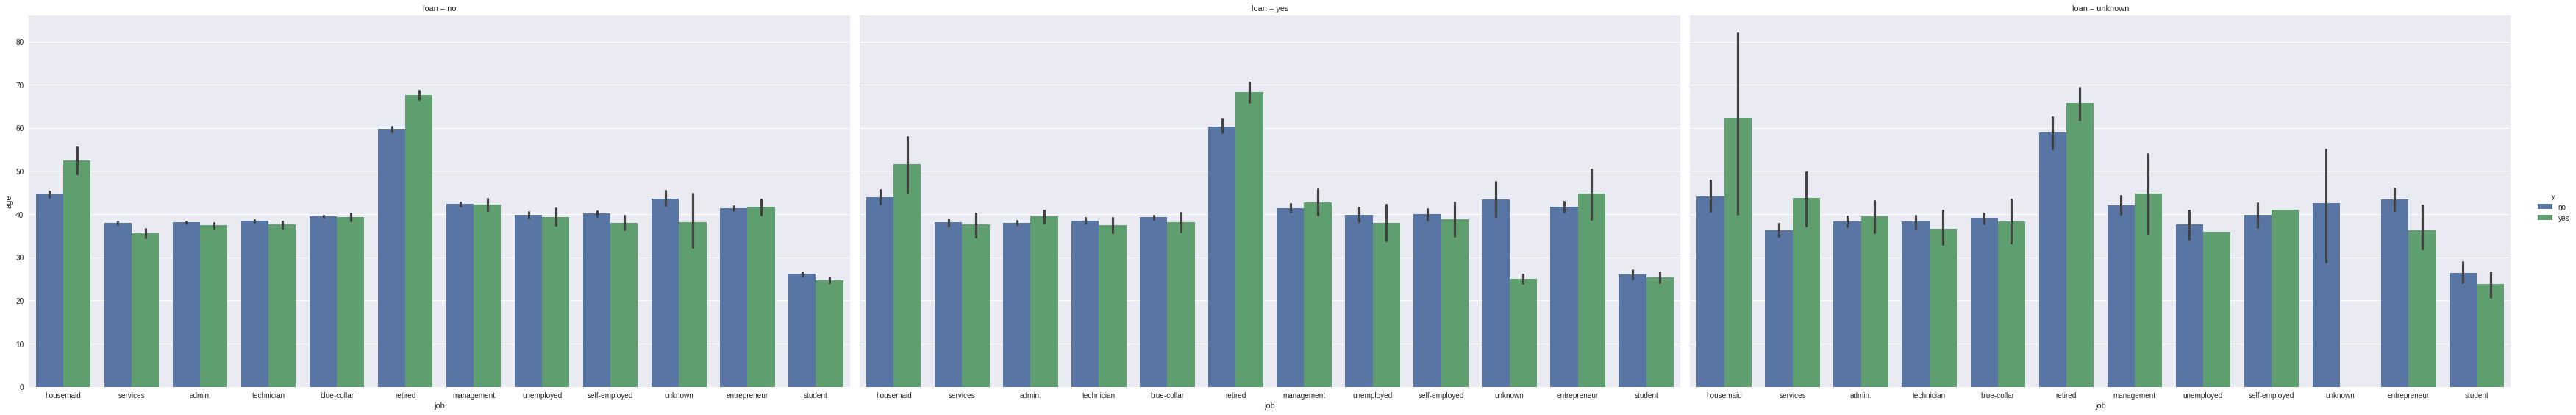

In [0]:
sns.factorplot(x='job', 
               y='age', 
               data=df, 
               hue='y',  
               col='loan',
               kind = 'bar',
               size = 8,
              aspect = 2) 

In [0]:
df["marital"].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



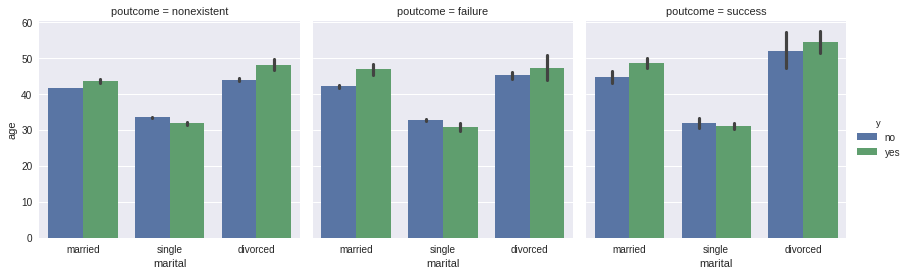

In [0]:
sns.factorplot(x='marital', 
               y='age', 
               data=df, 
               hue='y',  
               col='poutcome',
               kind = 'bar') 
                  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



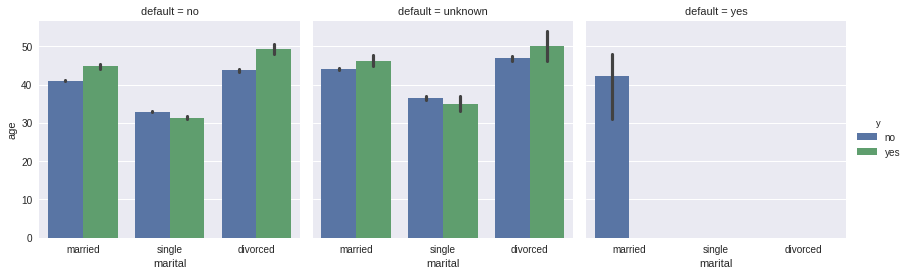

In [0]:
sns.factorplot(x='marital', 
               y='age', 
               data=df, 
               hue='y',  
               col='default',
               kind = 'bar') 
                   

Mostly married people have credit in default, thus they do not subscrive to term deposit

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



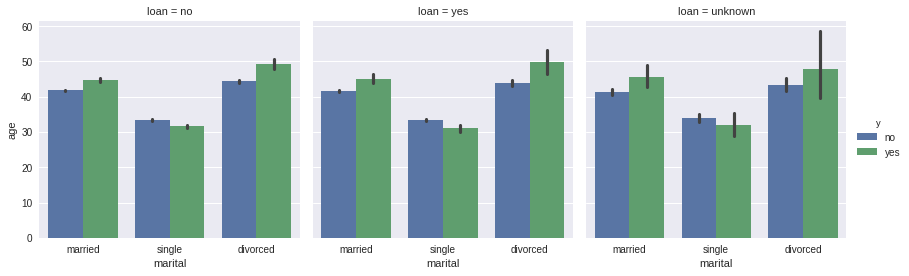

In [0]:
sns.factorplot(x='marital', 
               y='age', 
               data=df, 
               hue='y',  
               col='loan',
               kind = 'bar') 
                   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



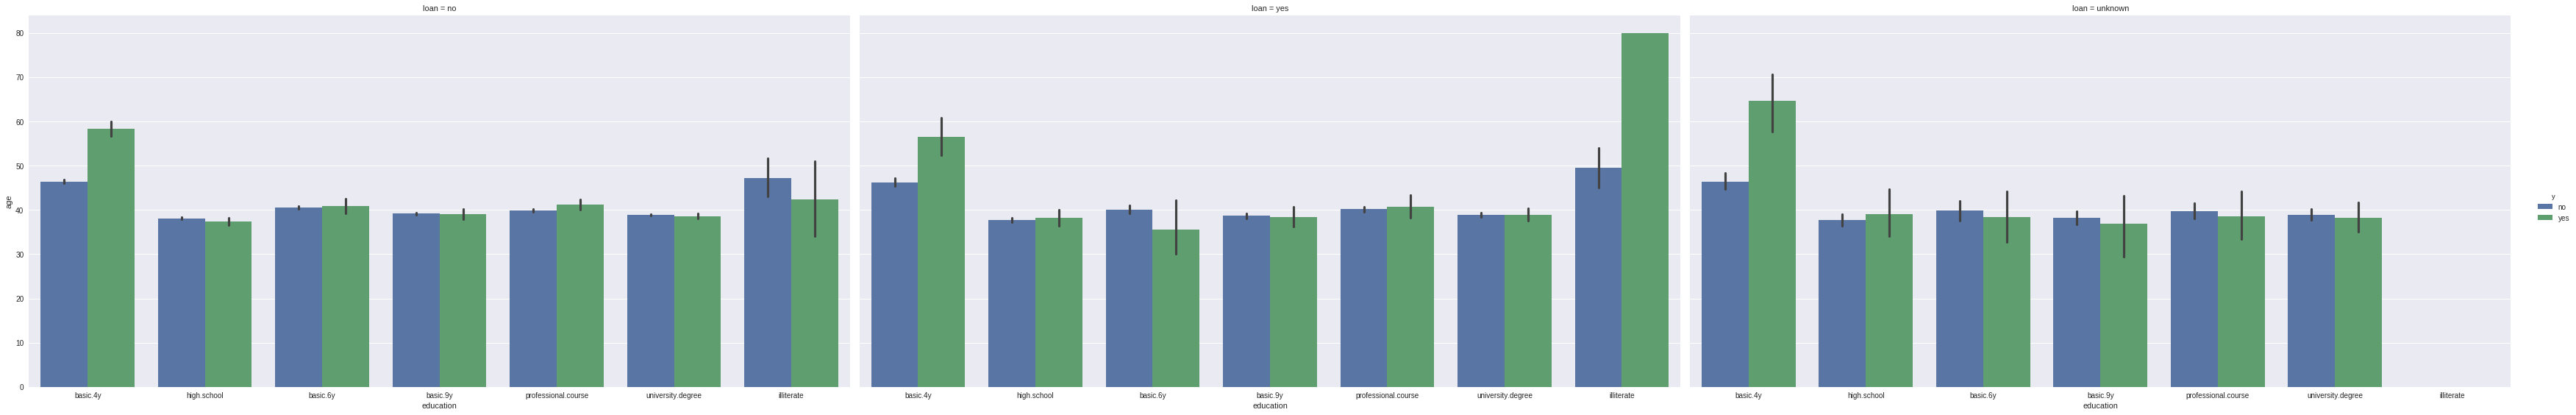

In [0]:
sns.factorplot(x='education', 
               y='age', 
               data=df, 
               hue='y',  
               col='loan',
               kind = 'bar',
               size = 8,
              aspect = 2) 
                   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



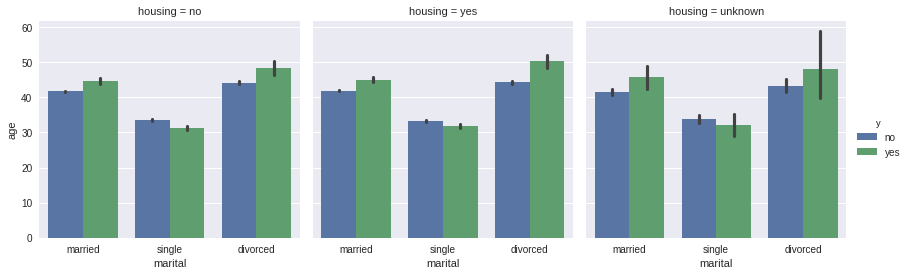

In [0]:
sns.factorplot(x='marital', 
               y='age', 
               data=df, 
               hue='y',  
               col='housing',
               kind = 'bar') 
                   

###  **The age, marital status, job, and education matters a lot to features such as housing, loan,  credit default**

In [11]:
df["education"].value_counts()/len(df) *100

university.degree      29.542585
high.school            23.101389
basic.9y               14.676605
professional.course    12.729436
basic.4y               10.138875
basic.6y                5.564728
unknown                 4.202680
illiterate              0.043702
Name: education, dtype: float64

In [0]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [0]:
df["loan"].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [0]:
df["month"].value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



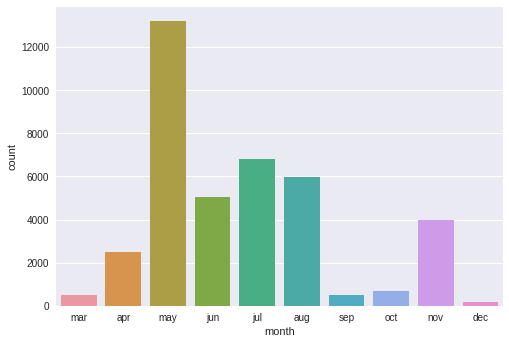

In [0]:
labels = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
sns.countplot(x='month', data=df, order = labels)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



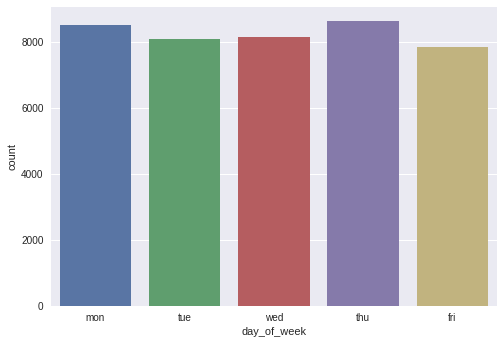

In [0]:
sns.countplot(x='day_of_week', data=df)

In [0]:
df["housing"].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



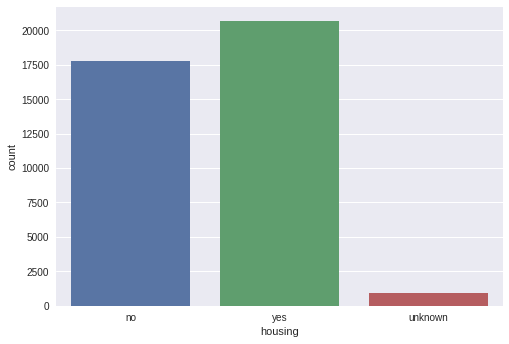

In [0]:
sns.countplot(x='housing', data=df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



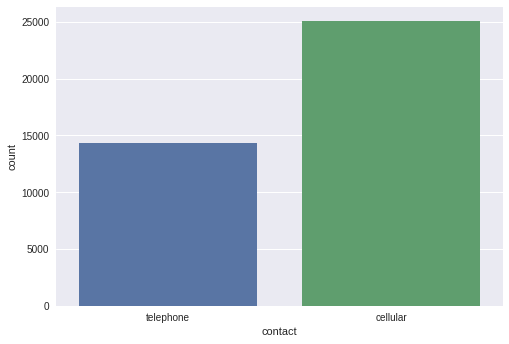

In [0]:
sns.countplot(x='contact', data=df)

In [0]:
for i in df.columns :
    print(pd.crosstab(df[i],df.y,margins=True,normalize='index'))

y          no       yes
age                    
17   0.600000  0.400000
18   0.571429  0.428571
19   0.523810  0.476190
20   0.646154  0.353846
21   0.715686  0.284314
22   0.737226  0.262774
23   0.787611  0.212389
24   0.814255  0.185745
25   0.844482  0.155518
26   0.825215  0.174785
27   0.866040  0.133960
28   0.849151  0.150849
29   0.871989  0.128011
30   0.882147  0.117853
31   0.887006  0.112994
32   0.900325  0.099675
33   0.885434  0.114566
34   0.894556  0.105444
35   0.905060  0.094940
36   0.913483  0.086517
37   0.907119  0.092881
38   0.898365  0.101635
39   0.920391  0.079609
40   0.927649  0.072351
41   0.911581  0.088419
42   0.920315  0.079685
43   0.916588  0.083412
44   0.923838  0.076162
45   0.916591  0.083409
46   0.923301  0.076699
..        ...       ...
66   0.491228  0.508772
67   0.576923  0.423077
68   0.545455  0.454545
69   0.588235  0.411765
70   0.595745  0.404255
71   0.603774  0.396226
72   0.617647  0.382353
73   0.617647  0.382353
74   0.531250  0

In [0]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Using one-hot encoding on the categorical features of the dataset

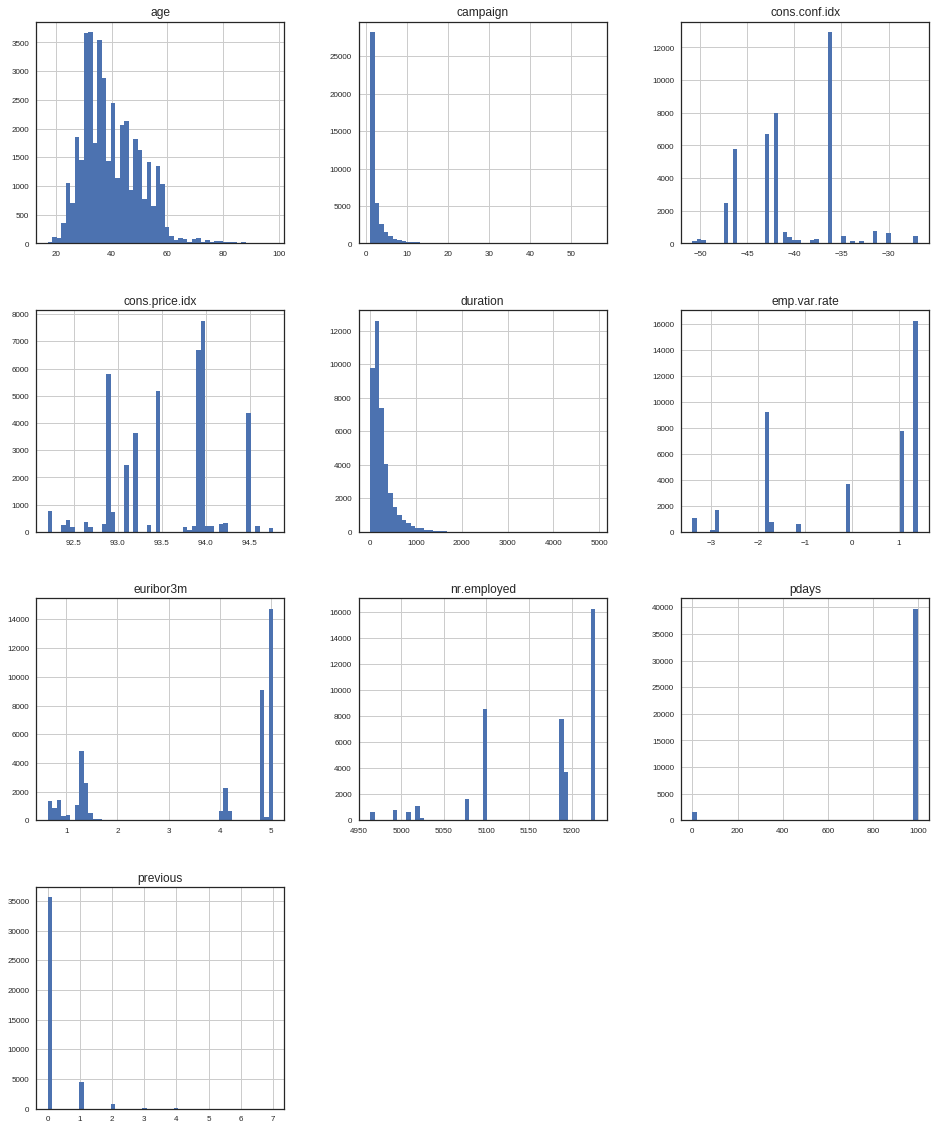

In [0]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

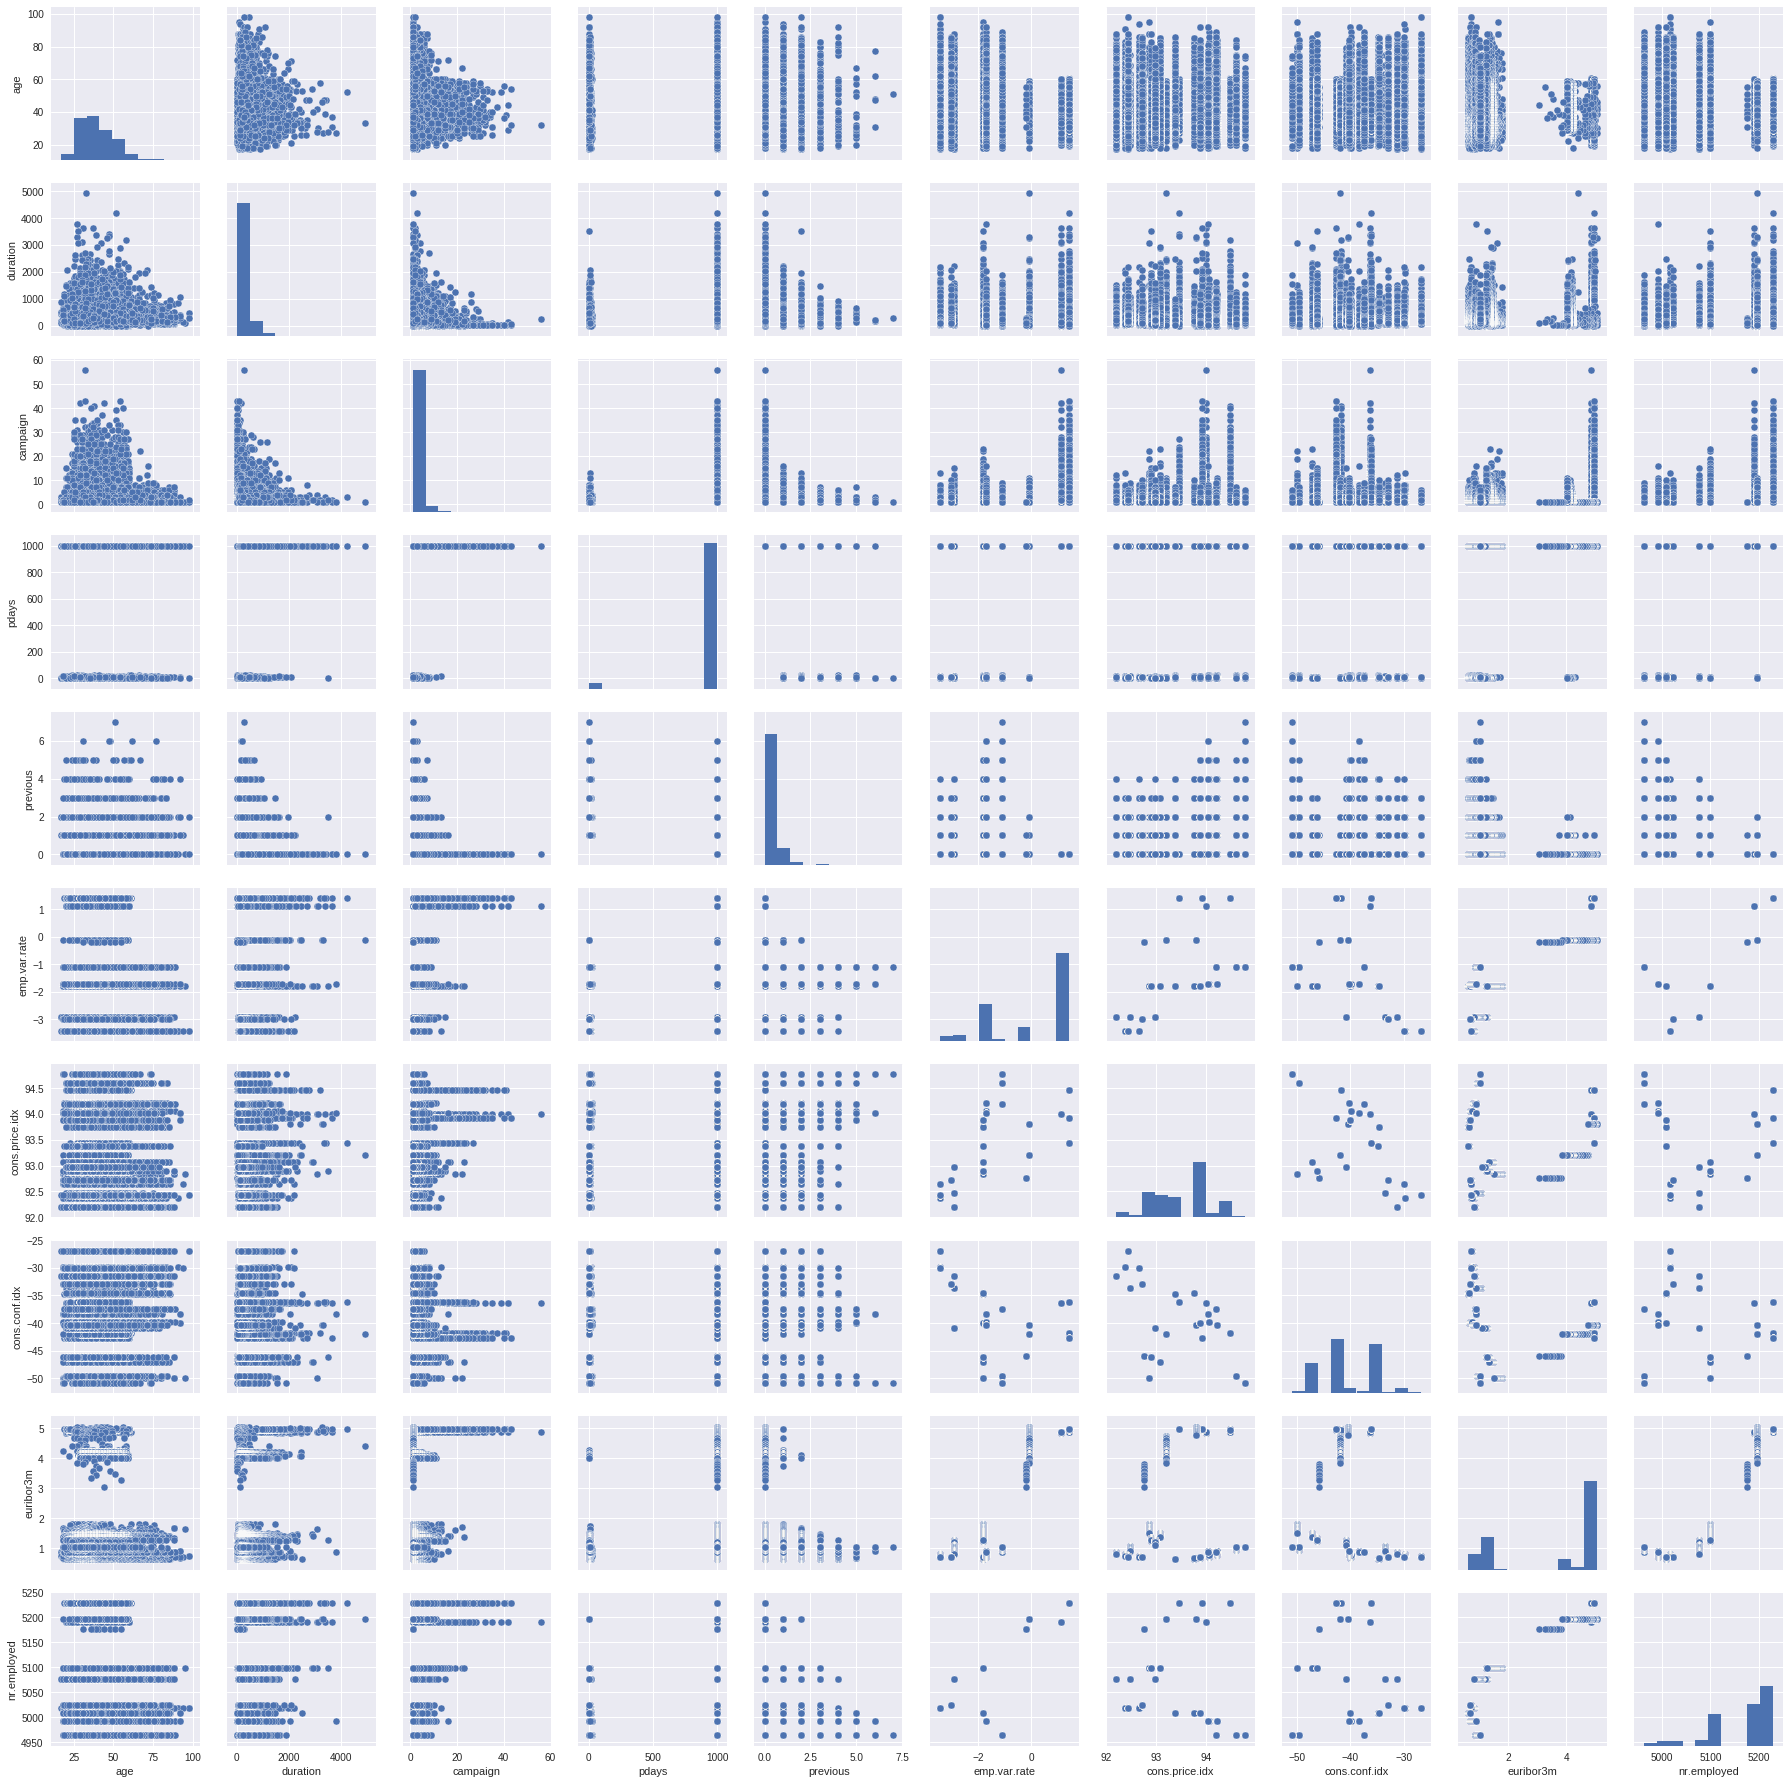

In [0]:
sns.pairplot(df)

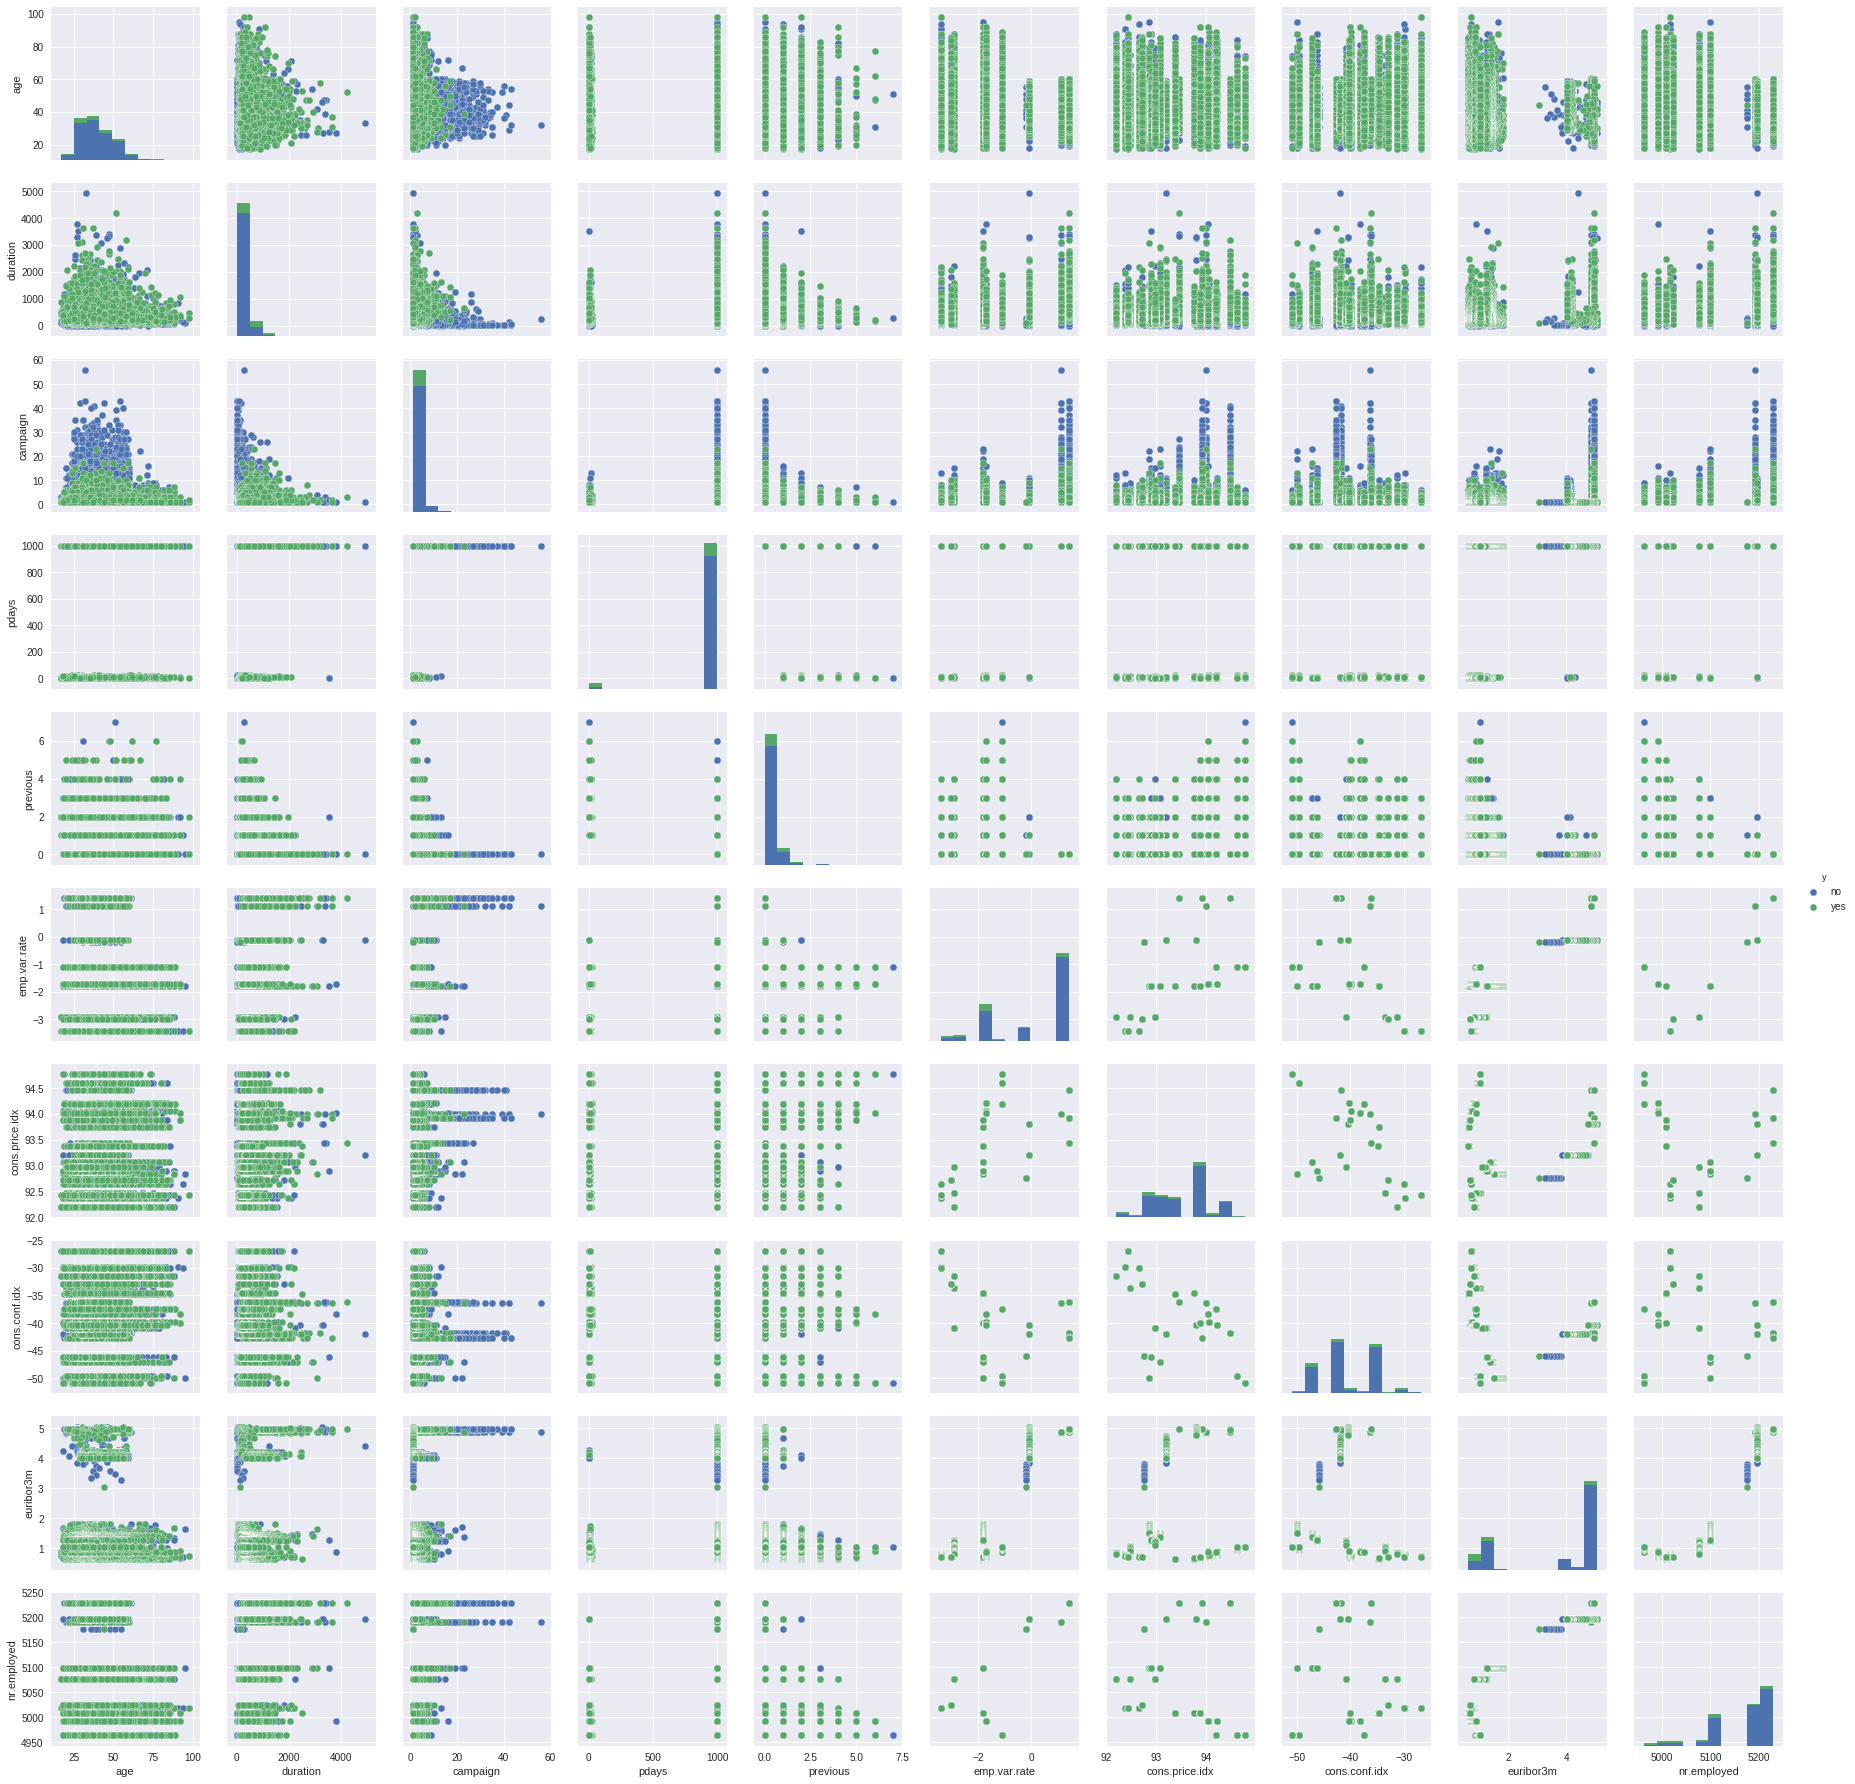

In [0]:
sns.pairplot(df,hue = "y")

In [0]:
df["y"].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Text(0, 0.5, 'Frequency')

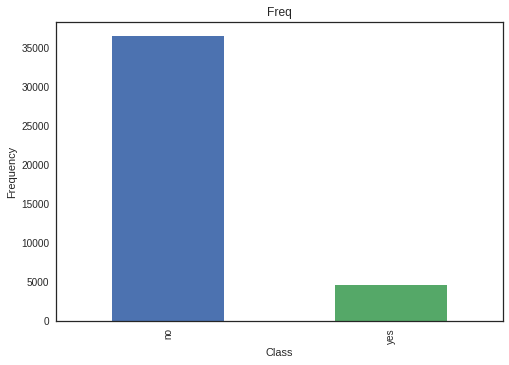

In [0]:
count_classes = pd.value_counts(df['y'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Freq")
plt.xlabel("Class")
plt.ylabel("Frequency")

The above plot indicates that the dataset is imbalanced. 
"yes" is only 12%

### In the below code :
*  "unknown" or missing values in categorical features are replaced the mode of the respective columns
*  One hot encoding is done on the categorical features

In [0]:
f_cat = ["job","marital","education","default","housing","loan","contact","month","day_of_week","poutcome"]
for f in f_cat :
  mode = df[f].mode()
  df[f].fillna(mode,inplace=True)

In [0]:
df_new = pd.get_dummies(df,columns = f_cat)

Also converting "y" (target) into binary

In [0]:
df_new.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [40]:
df_new.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


###  Upsampling the minority class ( "y") to compensate the imbalance in the data

In [0]:
ndf_majority = df_new[df_new.y == 0]
ndf_minority = df_new[df_new.y == 1]

In [0]:
# Upsample minority class
df_minority_upsampled = resample(ndf_minority,
                                 replace=True,  # sample with replacement
                                 n_samples=20000,  # to match majority class
                                 random_state=123)


In [0]:
df_sampled = pd.concat([ndf_majority, df_minority_upsampled])

In [0]:
X_s = df_sampled.drop(["y"],axis=1)
y_s = df_sampled["y"]

### Splitiing data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=2)

## Applying Logistic Regression 

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
model = LogisticRegression()

In [77]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred = model.predict(X_test)

In [79]:
print('confusion matrix')
print(metrics.confusion_matrix(y_test, pred))
print('classification report')
print(metrics.classification_report(y_test, pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, pred)))

confusion matrix
[[6614  698]
 [ 833 3165]]
classification report
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7312
           1       0.82      0.79      0.81      3998

   micro avg       0.86      0.86      0.86     11310
   macro avg       0.85      0.85      0.85     11310
weighted avg       0.86      0.86      0.86     11310

-----------------------------------------------------------------------------------------
Accuracy is :
0.864633068081344
Area under the curve : 0.848093


## Applying Xgboost Algorithm 

Why ?
* robust to outliers
* deals with missing values
* fast computation
* works well with one hot encoding, handles sparse matrix

In [80]:
clf = XGBClassifier(max_depth = 4, min_child_weight = 2,gamma=0.1)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

In [82]:
%time clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True, early_stopping_rounds=15)

[0]	validation_0-auc:0.9173	validation_0-error:0.134091	validation_1-auc:0.919661	validation_1-error:0.131565
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-auc:0.921127	validation_0-error:0.132168	validation_1-auc:0.924182	validation_1-error:0.129443
[2]	validation_0-auc:0.929637	validation_0-error:0.132101	validation_1-auc:0.931674	validation_1-error:0.129443
[3]	validation_0-auc:0.931687	validation_0-error:0.1323	validation_1-auc:0.934018	validation_1-error:0.129443
[4]	validation_0-auc:0.935681	validation_0-error:0.127371	validation_1-auc:0.938495	validation_1-error:0.127144
[5]	validation_0-auc:0.936366	validation_0-error:0.127304	validation_1-auc:0.939021	validation_1-error:0.127851
[6]	validation_0-auc:0.937489	validation_0-error:0.127061	validation_1-auc:0.939862	validation_1-error:0.127851
[7]	validation_0-auc:0.937962	validation_0-error:0.12516	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = clf.predict(X_test)

In [84]:
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

confusion matrix
[[6489  823]
 [ 390 3608]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7312
           1       0.81      0.90      0.86      3998

   micro avg       0.89      0.89      0.89     11310
   macro avg       0.88      0.89      0.89     11310
weighted avg       0.90      0.89      0.89     11310

-----------------------------------------------------------------------------------------
Accuracy is :
0.8927497789566755
Area under the curve : 0.894948


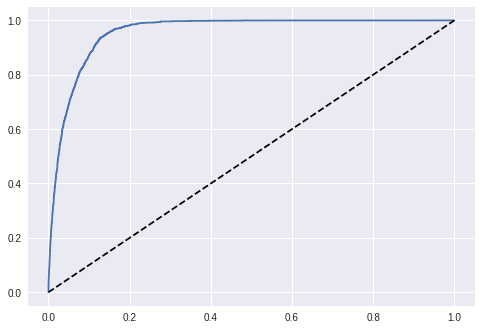

In [85]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

** Xgboost gives better results !**